In [1]:
from tensorly.decomposition.candecomp_parafac import *
# from tensorly.decomposition import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import NMF,non_negative_factorization
from tensorly.kruskal_tensor import *

In [2]:
df_test = pd.read_csv('./PARAFAC implementation/Testing Data/K036VRÁS-RS211.csv',index_col=0)
df_test.index = pd.DatetimeIndex(df_test.CTime)
df_test = df_test.loc[df_test.OkPct >= 98]
df_test = df_test.loc[df_test.Flag == 524480]


In [3]:
x = df_test.loc[(df_test.CType == 4) & (df_test.Val > 0),:].Val
x = x.resample('1h').mean()
x = x.fillna(method='ffill')
weekhour_index = x.index.weekday * 24 + x.index.hour
first_0 = np.argwhere(weekhour_index == 0)[0,0]
last_0 = np.argwhere(weekhour_index == 0)[-1,0]
x = x.iloc[first_0:last_0]
X = x.values.reshape((-1,7,24))

In [4]:
X = X.reshape(-1,24*7)

In [5]:
X.shape

(683, 168)

In [6]:
from scipy.optimize import nnls
def predict_one_week(b,y):
    # Solve the problem of xb = y
    
    x = nnls(b,y,)
    return x[0]

def get_strides_and_shift(array,window = 168):   
    n = array.shape[0] - window + 1
    arr_strided = np.lib.stride_tricks.as_strided(array, shape=[n, window], strides=2*array.strides)
    shifts = np.arange(0,len(arr_strided))%168
    return arr_strided,shifts

In [33]:
model_list = []

In [8]:
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning



# @ignore_warnings(category=ConvergenceWarning)    
# def NMF_with_flat_factor(X,
#                          n_components,
#                          max_iter=10000,
#                          tol = 1e-10,
#                          return_error = False,
#                          beta_loss = 'kullback-leibler',
#                          solver='mu',
#                          alpha=0.0,
#                          l1_ratio=0.0,
#                          regularization=None,):
#     n,p = X.shape
    
#     nmf = NMF(n_components=3,init='custom',max_iter = 1,tol=1e-10,beta_loss = beta_loss, solver=solver)
    
#     H_init = np.abs(np.random.normal(0,1,(n_components,p)))
#     H_init[0] = np.ones(p)/(p**(1/2))
#     W_init = np.abs(np.random.normal(0,1,(n, n_components)))
    
#     W = nmf.fit_transform(X,H=H_init,W=W_init)
#     H = nmf.components_
    
#     last_error = 10e10
#     if return_error:
#         errors = []
#     for i in range(max_iter-1):
#         W,H = compute_NMF_step(X = X,
#                                W = W,
#                                H = H,
#                                tol = 1e-10,
#                                beta_loss = beta_loss,
#                                solver = solver)
        
#         mse = np.mean((X - W@H)**2)
#         errors.append(mse)
#         if (last_error - mse) < tol:
#             break
#         else:
#             last_error = mse
        
#     nmf.fit(X,H=H,W=W)
#     return nmf,errors

C:\Users\Sverrir\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [9]:
# NMF(n_components=3,init='random',max_iter = 10000,tol=1e-10,).fit_transform(X)

In [ ]:
from sklearn.base import BaseEstimator
class NMF_custom(BaseEstimator):
    def __init__(self,
                 X=None,
                 n_components=3,
                 max_iter=10000,
                 tol = 1e-10,
                 return_error = False,
                 beta_loss = 'kullback-leibler',
                 solver='mu',
                 alpha=0.0,                   
                 l1_ratio=0.0,
                 regularization='components',
                 name = 'Custom NMF implementation with a single flat profile',
                 errors = []):
        
        self.params = {
            'n_components' : n_components,
            'max_iter' : max_iter,
            'tol' : tol,
            'beta_loss' : beta_loss,
            'solver' : solver,
            'alpha' : alpha,
            'l1_ratio' : l1_ratio,
            'regularization' : regularization,
            'name':'Custom NMF implementation with a single flat profile',
            
        }
        self.errors = []
            

        
    @ignore_warnings(category=ConvergenceWarning)    
    def compute_NMF_step(self):
        self.W, self.H, _ = non_negative_factorization(X = self.X,
                                             W = self.W,
                                             H = self.H,
                                             n_components=self.params['n_components'],
                                             init='custom',
                                             update_H=True,
                                             solver=self.params['solver'],
                                             beta_loss=self.params['beta_loss'],
                                             tol=self.params['tol'],
                                             max_iter=1,
                                             alpha=self.params['alpha'],
                                             l1_ratio=self.params['l1_ratio'],
                                             regularization=self.params['regularization'],
                                             random_state=None,
                                             verbose=0,
                                             shuffle=False)
        p = X.shape[1]
        self.H[0] = np.ones((1,p))/(p**(1/2))

    
    def get_params(self,deep=False):
        return self.params
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            self.params[parameter] = value
            
        return self
    
    def fit(self,data,y=None):
        
        print(self.params)
        self.nmf = NMF(n_components=self.params['n_components'],
                       init='custom',
                       max_iter = 1,
                       tol=1e-10,
                       beta_loss = self.params['beta_loss'],
                       solver = self.params['solver'],
                       alpha = self.params['alpha'],
                       l1_ratio = self.params['l1_ratio'])
            
            
        self.X = data
        self.n,self.p = self.X.shape
        
        self.H = np.abs(np.random.normal(0,1,(self.params['n_components'],self.p)))
        self.H[0] = np.ones(self.p)/(self.p**(1/2))
        
        self.W = np.abs(np.random.normal(0,1,(self.n, self.params['n_components'])))
        
        last_error = 10e10
        for i in range(self.params['max_iter']-1):
            self.compute_NMF_step()
#             self.compute_NMF_step(X = self.X,W = self.W,
#                                   H = self.H,
#                                   tol = 1e-10,
#                                   beta_loss = self.params['beta_loss'],
#                                   solver = self.params['solver'],
#                                   alpha=self.params['alpha'],
#                                   l1_ratio=self.params['l1_ratio'])

            mse = np.mean((self.X - self.W@self.H)**2)
            self.errors.append(mse)
            if (last_error - mse) < self.params['tol']:
                self.nmf.fit(self.X,H=self.H,W=self.W)
                break
            else:
                last_error = mse
                
        self.nmf.fit(self.X,H=self.H,W=self.W)
        
        
    def fit_transform(self,data,y=None):
        self.fit(data)
        return self.transform(data)
        
    
    def transform(self,data):
        return self.nmf.inverse_transform(self.nmf.transform(data))
        
    def predict(self,data):
        return self.transform(data)

In [31]:
nmf_custom = NMF_custom(max_iter=100)
nmf_custom.fit(X)

{'n_components': 3, 'max_iter': 100, 'tol': 1e-10, 'beta_loss': 'kullback-leibler', 'solver': 'mu', 'alpha': 0.0, 'l1_ratio': 0.0, 'regularization': 'components', 'name': 'Custom NMF implementation with a single flat profile', 'errors': []}
(3, 168) (683, 3)


C:\Users\Sverrir\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 1 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [32]:
model_list

[{'parameters': {'n_components': 3,
   'max_iter': 100,
   'tol': 1e-10,
   'beta_loss': 'kullback-leibler',
   'solver': 'mu',
   'alpha': 0.0,
   'l1_ratio': 0.0,
   'regularization': ['components'],
   'name': 'Custom NMF implementation with a single flat profile',
   'errors': []}},
 {'n_components': 3,
  'max_iter': 100,
  'tol': 1e-10,
  'beta_loss': 'kullback-leibler',
  'solver': 'mu',
  'alpha': 0.0,
  'l1_ratio': 0.0,
  'regularization': ['components'],
  'name': 'Custom NMF implementation with a single flat profile',
  'errors': []},
 {'n_components': 3,
  'max_iter': 100,
  'tol': 1e-10,
  'beta_loss': 'kullback-leibler',
  'solver': 'mu',
  'alpha': 0.0,
  'l1_ratio': 0.0,
  'regularization': 'components',
  'name': 'Custom NMF implementation with a single flat profile',
  'errors': []}]

In [ ]:
neg_mean_squared_error_scorer(nmf_custom,X,X_re)

In [ ]:
from sklearn.utils.estimator_checks import check_estimator

In [ ]:
check_estimator(NMF_custom)

In [ ]:
nmf,errors = NMF_with_flat_factor(X,
                                  3,
                                  max_iter=10000,
                                  tol = 0,
                                  return_error=True,
                                  beta_loss = 'frobenius',
                                  solver='cd')

In [ ]:
plt.plot(-np.diff(errors))
plt.yscale('log')
plt.ylim(10e-20,10)

In [ ]:
X_re_min = np.array([predict_one_week(H.T,y).reshape(1,3)@H for y in X]).ravel()

In [ ]:
plt.plot(errors)

In [ ]:
plt.plot(1*(np.diff(errors)>0))

In [ ]:
W = nmf.transform(X)
H = nmf.components_
X_re = W@H

In [ ]:
MSE_re = np.mean((X.ravel() - X_re.ravel())**2)
MSE_re_inv = np.mean((X.ravel() - X_inv.ravel())**2)
MSE_re_min = np.mean((X.ravel() - X_re_min.ravel())**2)

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(X.ravel(),alpha=0.5)
plt.plot(X_re.ravel(),alpha=.5)
plt.plot(X_inv.ravel(),alpha=.5)
plt.plot(X_re_min.ravel(),alpha=.5)
plt.legend(['original','WH','inv','LstSq'])

In [ ]:
print(MSE_re)
print(MSE_re_inv)
print(MSE_re_min)

In [ ]:
print(MSE_re)
print(MSE_re_inv)
print(MSE_re_min)

In [ ]:
plt.plot(X.ravel(),alpha=0.5)
plt.plot(X_re.ravel(),alpha=0.5)

In [34]:
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV
from sklearn.metrics import make_scorer,mean_squared_error
neg_mean_squared_error_scorer = make_scorer(mean_squared_error,greater_is_better=False)


In [35]:
nmf_tmp = NMF_custom(None,3,100,1e-10,False,'kullback-leibler','mu',0.0,0.0)
nmf_tmp.fit(X)
print(neg_mean_squared_error_scorer(nmf_tmp,X,X_re))

nmf_tmp = NMF_custom(None,3,100,1e-10,False,'kullback-leibler','mu',0.5,100)
nmf_tmp.fit(X)
print(neg_mean_squared_error_scorer(nmf_tmp,X,X_re))

{'n_components': 3, 'max_iter': 100, 'tol': 1e-10, 'beta_loss': 'kullback-leibler', 'solver': 'mu', 'alpha': 0.0, 'l1_ratio': 0.0, 'regularization': 'components', 'name': 'Custom NMF implementation with a single flat profile', 'errors': []}
(3, 168) (683, 3)


C:\Users\Sverrir\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 1 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


NameError: name 'X_re' is not defined

In [163]:
n,p = X.shape
n_train = n//2
X_train,X_test = X[:n_train],X[n_train:]

n_components = np.arange(3,10,1)
alpha = np.linspace(0,20,5)
l1_ratio = np.linspace(0,1,5)
regularization = ['both', 'components', 'transformation' ]

param_grid = {
     'n_components':n_components,
     'alpha':alpha,
     'l1_ratio':l1_ratio,
     'regularization':regularization
}

splits = TimeSeriesSplit(max_train_size=None, n_splits=3)

In [164]:
def save_results():
    pass

In [108]:
param_grid

{'n_components': array([ 2,  5,  8, 11, 14]),
 'alpha': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
        1.00000000e+03]),
 'l1_ratio': array([1.00000000e-10, 3.16227766e-08, 1.00000000e-05, 3.16227766e-03,
        1.00000000e+00]),
 'regularization': ['both']}

In [115]:
nmf_custom = NMF_custom(max_iter=5000)

search = GridSearchCV(nmf_custom,
                      param_grid,
                      scoring=neg_mean_squared_error_scorer,
                      n_jobs=8,
                      iid='deprecated',
                      refit=True,
                      cv=splits, 
                      verbose=2,
                      pre_dispatch='2*n_jobs',
                      error_score='raise',
                      return_train_score=True)

In [169]:
import json


json.dumps(search.cv_results_)

TypeError: Object of type ndarray is not JSON serializable

In [187]:
import datetime as dt
fields = ['split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score']
data = np.array([search.cv_results_[t] for t in fields])
result_df = pd.DataFrame(data.T,index=search.cv_results_['params'],columns=fields)
time_now = dt.datetime.now()
date_string = time_now.strftime(format='%Y_%m_%d_%H%M%S')
result_df.to_csv(f'./hyperparameter tuning results/{date_string}.csv')

'2020_10_08_091643'

In [170]:
search.cv_results_.keys()


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_alpha', 'param_l1_ratio', 'param_n_components', 'param_regularization', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])

In [116]:
search.fit(X=X,y=X,)

Fitting 3 folds for each of 125 candidates, totalling 375 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.7min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 11.6min
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed: 17.5min
[Parallel(n_jobs=8)]: Done 375 out of 375 | elapsed: 17.8min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score='raise', estimator=NMF_custom(max_iter=5000), n_jobs=8,
             param_grid={'alpha': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'l1_ratio': array([1.00000000e-10, 3.16227766e-08, 1.00000000e-05, 3.16227766e-03,
       1.00000000e+00]),
                         'n_components': array([ 2,  5,  8, 11, 14]),
                         'regularization': ['both']},
             refit=False, return_train_score=True,
             scoring=make_scorer(mean_squared_error, greater_is_better=False),
             verbose=2)

In [117]:
# search.fit(X=X,y=X,)

In [118]:
# search.fit(X=X,y=X,)

In [119]:
performance = search.cv_results_['mean_test_score']

In [126]:
np.max(performance)

-0.13925192006527723

In [127]:
search.best_params_

{'alpha': 1.0, 'l1_ratio': 1.0, 'n_components': 5, 'regularization': 'both'}

In [ ]:
search.b

In [122]:
performance_tensor = performance.reshape(tuple(len(tmp) for tmp in param_grid.values()))

In [123]:
tmp = [1,2,3]
tmp.remove(1)
tmp

[2, 3]

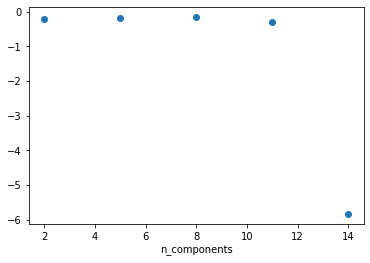

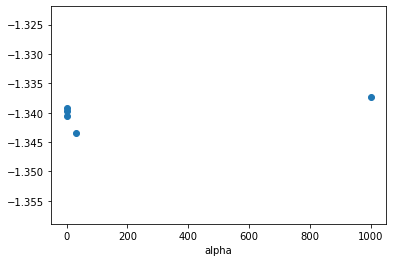

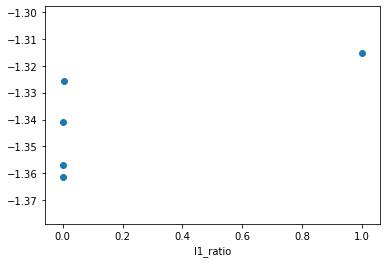

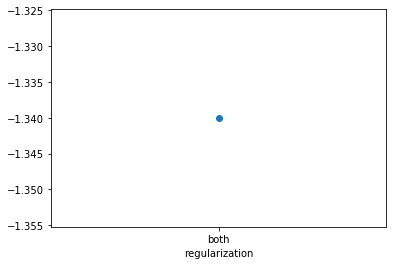

In [124]:
for i,param in enumerate(param_grid.keys()):
    axes = list(np.arange(4))
    axes.remove(i)
    plt.scatter(list(param_grid[param]),np.mean(performance_tensor,axis=tuple(axes)))
    plt.xlabel(param)
    plt.show()

In [128]:
search.best_params_

{'alpha': 1.0, 'l1_ratio': 1.0, 'n_components': 5, 'regularization': 'both'}

In [130]:
nmf_custom = NMF_custom(X=None,
                        n_components=5,
                        max_iter=10000,
                        tol = 1e-10,
                        return_error = True,
                        beta_loss = 'kullback-leibler',
                        solver='mu',
                        alpha=1,                   
                        l1_ratio=1,
                        regularization='components',
                        name = 'Custom NMF implementation with a single flat profile',
                        errors = []
                       )
nmf_custom.fit(X)

{'n_components': 5, 'max_iter': 10000, 'tol': 1e-10, 'beta_loss': 'kullback-leibler', 'solver': 'mu', 'alpha': 1, 'l1_ratio': 1, 'regularization': 'components', 'name': 'Custom NMF implementation with a single flat profile'}
(5, 168) (683, 5)


C:\Users\Sverrir\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 1 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
C:\Users\Sverrir\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 1 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [136]:
compoenents = nmf_custom.nmf.components_
compoenents = nmf_custom.nmf.components_

In [139]:
X_re_min = np.array([predict_one_week(compoenents.T,y).reshape(1,-1)@compoenents for y in X]).ravel()

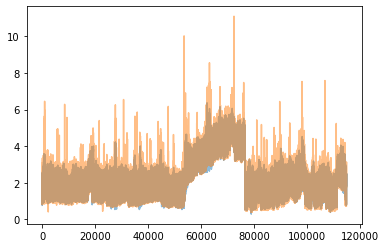

In [143]:
plt.plot(X_re_min,alpha=0.5)
plt.plot(X.ravel(),alpha=0.5)

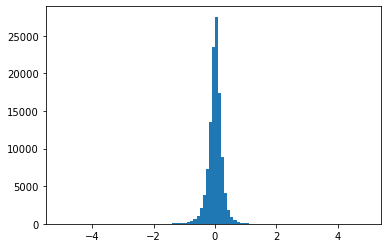

In [155]:
residuals = X_re_min-X.ravel()
plt.hist(residuals,bins=np.arange(-5,5,0.1))
plt.show()

In [154]:
from scipy.stats import kurtosis

In [162]:
print('mse:',np.mean(residuals**2))
print('mae:',np.mean(np.abs(residuals)))

mse: 0.059792586911277715
mae: 0.16453969936054325


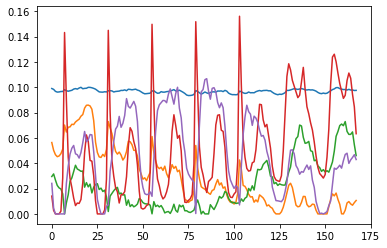

In [144]:
plt.plot(compoenents.T)

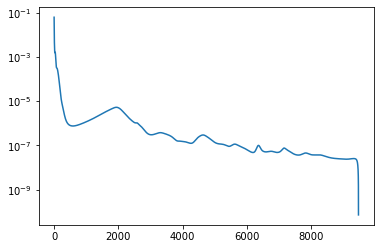

In [149]:

plt.plot(- np.diff(nmf_custom.errors))
plt.yscale('log')

In [ ]:
# nmf,errors = NMF_with_flat_factor(X,
#                                   3,
#                                   max_iter=10000,
#                                   tol = 0,
#                                   return_error=True,
#                                   beta_loss = 'frobenius',
#                                   solver='cd')